# Building a Report Picker eval

Based on the [examples in openai/evals](https://github.com/openai/evals/tree/26a5191230e91953f4f2fdd74a82051fda2aba23/examples)

In [27]:
%load_ext autoreload
%autoreload 2

import datetime
import os
import requests
import pandas as pd
import yaml
import json

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
# Construct the system prompt, similar to ../lib/openai.ts `createSystemPrompt`

# Read the prompt_template as a scalar value
with open("../lib/prompt_template.json") as f:
    prompt_template_data = json.load(f)
    prompt_template_prompt = prompt_template_data['prompt'] # Adjust this based on the actual structure

# Read the available_reports as a DataFrame
with open("../lib/available_reports/square.json") as f:
    available_reports = json.load(f)

sample_date = "2023-08-21"

# Construct the system prompt, BUT with the temp added lined until we solve using
# function calling in the API call
system_prompt = f"""
{prompt_template_prompt}

Today's date: {sample_date}

Reply with ONLY the key of a report below.

Available reports: 
{available_reports}
"""

system_prompt

'\nYou\'re an expert at finding the best report(s) to answer a user\'s question about their business. If the question isn\'t answerable by these reports, return "NA" as the "error".\n\nToday\'s date: 2023-08-21\n\nReply with ONLY the key of a report below.\n\nAvailable reports: \n[{\'key\': \'SalesSummary\', \'description\': \'Sales Summary: A general overview of sales from a given time period. The report includes itemization metrics like gross sales, refunds, net sales, discounts, tips, and taxes. It also includes payment metrics like total collected (revenue by tender type) and fees.\', \'filters\': [\'startDate\', \'endDate\']}, {\'key\': \'SalesTrends\', \'description\': \'Sales Trends: Compares your daily, weekly, and yearly gross sales.\', \'filters\': [\'startDate\', \'endDate\']}, {\'key\': \'PaymentMethods\', \'description\': \'Payment Methods: A summary of the total collected and any associated fees from credit, debit and gift cards, and any other tender types. The reports in

In [29]:
eval_key = "report_picker"
registry_path = os.path.join(os.getcwd(), ".local_registry")
os.makedirs(os.path.join(registry_path, "evals"), exist_ok=True)
os.makedirs(os.path.join(registry_path, "data", eval_key), exist_ok=True)

# display(registry_path)

def create_chat_prompt(user_question):
    return [
        {"role": "system", "content": system_prompt}, 
        {"role": "user", "content": user_question}
    ]

# Read the YAML file
yaml_file_path = os.path.join("report_questions.yaml")
with open(yaml_file_path, 'r') as f:
    yaml_data = yaml.load(f, Loader=yaml.FullLoader)

# Transform the dictionary
data = []
for key, questions in yaml_data.items():
    for question in questions:
        input_prompt = create_chat_prompt(question)
        data.append({"input": input_prompt, "ideal": key})

# Convert to a Pandas DataFrame
df = pd.DataFrame(data)

# Save to a JSON file
json_output_path = os.path.join(registry_path, "data", eval_key, "samples.jsonl")
df.to_json(json_output_path, orient="records", lines=True)

# Display the DataFrame
display(df.head())

,input,ideal
0,"[{'role': 'system', 'content': ' You're an exp...",SalesSummary
1,"[{'role': 'system', 'content': ' You're an exp...",SalesSummary
2,"[{'role': 'system', 'content': ' You're an exp...",SalesSummary
3,"[{'role': 'system', 'content': ' You're an exp...",SalesTrends
4,"[{'role': 'system', 'content': ' You're an exp...",SalesTrends


In [30]:
samples_path = os.path.join(registry_path, "data", eval_key, "samples.jsonl")

eval_yaml = f"""
{eval_key}:
  id: {eval_key}.test.v0
  metrics: [accuracy]

{eval_key}.test.v0:
  class: evals.elsuite.basic.match:Match
  args:
    samples_jsonl: {samples_path}
""".strip()

with open(os.path.join(registry_path, "evals", f"{eval_key}.yaml"), "w") as f:
    f.write(eval_yaml)

## Run the `oaieval` CLI tool

In [37]:
# Compare different models
model = "gpt-3.5-turbo"
# model = "gpt-4"

# Get the absolute path to the registry
abs_registry_path = os.path.abspath(registry_path)

# Create the results directory
results_dir = os.path.join(os.getcwd(), ".results")
os.makedirs(results_dir, exist_ok=True)
ts = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
results_file_name = f"{eval_key}-{model}-{ts}.jsonl"
abs_record_path = os.path.join(results_dir, results_file_name)

# Uncomment args as needed
extra_args = [
    # "--debug",
    # "--dry-run",
    # "--max_samples 5",
    f"--registry_path {abs_registry_path}",
    f"--record_path {abs_record_path}"
]

# Run the eval with paths passed in
get_ipython().system(f"oaieval {model} {eval_key} {' '.join(extra_args)}")

[2023-08-21 17:21:08,017] [registry.py:249] Loading registry from /Users/briansigafoos/Development/briansigafoos/report-picker-gpt/evals/venv/lib/python3.11/site-packages/evals/registry/evals
[2023-08-21 17:21:08,079] [registry.py:249] Loading registry from /Users/briansigafoos/.evals/evals
[2023-08-21 17:21:08,079] [registry.py:249] Loading registry from /Users/briansigafoos/Development/briansigafoos/report-picker-gpt/evals/.local_registry/evals
[2023-08-21 17:21:08,080] [oaieval.py:110] Run started: 230821212108WPXXJY6K
[2023-08-21 17:21:08,080] [data.py:75] Fetching /Users/briansigafoos/Development/briansigafoos/report-picker-gpt/evals/.local_registry/data/report_picker/samples.jsonl
[2023-08-21 17:21:08,081] [eval.py:34] Evaluating 60 samples
[2023-08-21 17:21:08,087] [eval.py:153] Running in threaded mode with 10 threads!
100%|███████████████████████████████████████████| 60/60 [00:01<00:00, 34.90it/s]
[2023-08-21 17:21:09,808] [record.py:320] Final report: {'accuracy': 0.733333333

<Axes: title={'center': 'Correctness of generated answers'}, xlabel='Correct', ylabel='Count'>

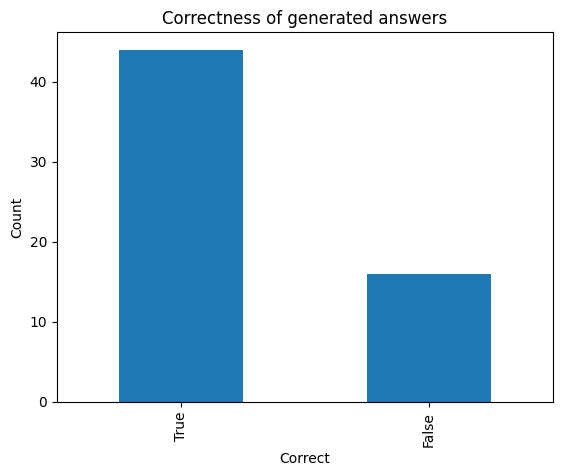

In [49]:
# Graph the results
with open(abs_record_path, "r") as f:
    df = pd.read_json(f, lines=True)

matches_df = df[events_df.type == "match"].reset_index(drop=True)
matches_df = df.join(pd.json_normalize(matches_df.data))
matches_df.correct.value_counts().plot.bar(title="Correctness of generated answers", xlabel="Correct", ylabel="Count")

In [53]:
# # Inspect mistakes
mistakes_df = matches_df[matches_df.correct == False]

# # Displays the expected and sampled columns
# mistakes_df[["expected", "sampled", "data"]]
mistakes_df

,spec,final_report,run_id,event_id,sample_id,type,data,created_by,created_at,correct,expected,picked,sampled,options
3,NaN,NaN,230821212108WPXXJY6K,1.0,report_picker.test.11,match,"{'correct': True, 'expected': 'ItemSales', 'pi...",,2023-08-21 21:21:08.437416+00:00,False,ActivityLog,None,Activity Log,[ActivityLog]
5,NaN,NaN,230821212108WPXXJY6K,3.0,report_picker.test.37,match,"{'correct': True, 'expected': 'TransactionStat...",,2023-08-21 21:21:08.446584+00:00,False,ActivityLog,None,NA,[ActivityLog]
8,NaN,NaN,230821212108WPXXJY6K,6.0,report_picker.test.54,sampling,"{'prompt': [{'role': 'system', 'content': ' Yo...",,2023-08-21 21:21:08.456211+00:00,False,CashDrawers,None,NA,[CashDrawers]
12,NaN,NaN,230821212108WPXXJY6K,10.0,report_picker.test.55,sampling,"{'prompt': [{'role': 'system', 'content': ' Yo...",,2023-08-21 21:21:08.463160+00:00,False,Voids,None,NA,[Voids]
14,NaN,NaN,230821212108WPXXJY6K,12.0,report_picker.test.23,sampling,"{'prompt': [{'role': 'system', 'content': ' Yo...",,2023-08-21 21:21:08.477005+00:00,False,Discounts,None,Key: Discounts,[Discounts]
15,NaN,NaN,230821212108WPXXJY6K,13.0,report_picker.test.23,match,"{'correct': True, 'expected': 'Discounts', 'pi...",,2023-08-21 21:21:08.477023+00:00,False,Transactions,None,ItemSales,[Transactions]
18,NaN,NaN,230821212108WPXXJY6K,16.0,report_picker.test.53,sampling,"{'prompt': [{'role': 'system', 'content': ' Yo...",,2023-08-21 21:21:08.499611+00:00,False,LaborVsSales,None,Labor vs. Sales,[LaborVsSales]
21,NaN,NaN,230821212108WPXXJY6K,19.0,report_picker.test.16,match,"{'correct': True, 'expected': 'TeamMemberSales...",,2023-08-21 21:21:08.519621+00:00,False,Disputes,None,NA,[Disputes]
23,NaN,NaN,230821212108WPXXJY6K,21.0,report_picker.test.30,match,"{'correct': True, 'expected': 'Voids', 'picked...",,2023-08-21 21:21:08.686265+00:00,False,ModifierSales,None,NA,[ModifierSales]
26,NaN,NaN,230821212108WPXXJY6K,24.0,report_picker.test.32,sampling,"{'prompt': [{'role': 'system', 'content': ' Yo...",,2023-08-21 21:21:08.708250+00:00,False,GiftCards,None,NA,[GiftCards]


In [47]:
for i, r in pd.json_normalize(events_df[events_df.type == "sampling"].data).iterrows():
    print(f"Prompt: {r.prompt}")
    print(f"Sampled: {r.sampled}")
    print("-" * 25)

Prompt: [{'role': 'system', 'content': '\nYou\'re an expert at finding the best report(s) to answer a user\'s question about their business. If the question isn\'t answerable by these reports, return "NA" as the "error".\n\nToday\'s date: 2023-08-21\n\nReply with ONLY the key of a report below.\n\nAvailable reports: \n[{\'key\': \'SalesSummary\', \'description\': \'Sales Summary: A general overview of sales from a given time period. The report includes itemization metrics like gross sales, refunds, net sales, discounts, tips, and taxes. It also includes payment metrics like total collected (revenue by tender type) and fees.\', \'filters\': [\'startDate\', \'endDate\']}, {\'key\': \'SalesTrends\', \'description\': \'Sales Trends: Compares your daily, weekly, and yearly gross sales.\', \'filters\': [\'startDate\', \'endDate\']}, {\'key\': \'PaymentMethods\', \'description\': \'Payment Methods: A summary of the total collected and any associated fees from credit, debit and gift cards, and